In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [107]:
def testStrategy(prices, signals):
    pnl = 0
    tradenum = 0
    for i in range(len(prices)):
        for j in range(len(signals[i])):
            if (signals[i][j] == 1): #buy
                pnl -= prices[i][j]
                tradenum += 1
            if (signals[i][j] == -1): #sell
                pnl += prices[i][j]
                tradenum += 1
    return pnl, tradenum

def tradeHist(prices, signals):
    tradehistfinal = []
    for i in range(len(prices)):
        tradeList = []
        tradeTrack = [0,0]
        for j in range(len(signals[i])):
            if signals[i][j] == 1: #buy
                tradeTrack[0] -= prices[i][j]
                tradeTrack[1] += 1
            if (signals[i][j] == -1): #sell
                tradeTrack[0] += prices[i][j]
                tradeTrack[1] += 1
            if (tradeTrack[1] % 2 == 0 and tradeTrack[1] > 0):
                tradeList.append(tradeTrack[0])
                tradeTrack[0] = 0
        tradehistfinal.append(tradeList)
    return tradehistfinal

def signalToXY(signal):
    signal = [0,0,0,0] + list(signal) + [0]
    trade = False
    for i in range(len(signal)):
        if (trade == True):
            signal[i] = -1*signal[i-1]
            trade = False
            continue

        if signal[i] != 0:
            trade = True
            
    XSignal = []
    YSignal = []
    for i in range(len(signal)):
        if (signal[i] == 1):
            XSignal.append(1)
            YSignal.append(-1)
            continue
        if (signal[i] == -1):
            XSignal.append(-1)
            YSignal.append(1)
            continue
        XSignal.append(0)
        YSignal.append(0)
    return XSignal, YSignal

def all_same(items):
    return all(x == items[0] for x in items)

In [108]:
dfXMaster = []
dfYMaster = []
signalXMaster = []
signalYMaster = []
signalXYMaster =  []
for i in range(1,12):
    dfX = pd.read_csv(".\\data\\dfX" + str(i) + ".csv")
    dfY = pd.read_csv(".\\data\\dfY" + str(i) + ".csv")
    signalX = pd.read_csv(".\\data\\signalX" + str(i) + ".csv")
    signalY = pd.read_csv(".\\data\\signalY" + str(i) + ".csv")

    signalY.rename(columns={"x": "y"}, inplace = True)
    dfX['mid'] = dfX['mid'].apply(lambda x: x/100)
    dfY['mid'] = dfY['mid'].apply(lambda x: x/100)
    signalXY = pd.DataFrame()
    signalXY['xy'] = -signalY['y']+signalX['x']
    
    dfXMaster.extend(list(dfX['mid']))
    dfYMaster.extend(list(dfY['mid']))
    signalXMaster.extend(list(signalX['x']))
    signalYMaster.extend(list(signalY['y']))
    signalXYMaster.extend(list(signalXY['xy']))

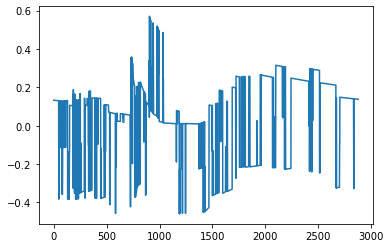

In [109]:
plt.plot(signalXY['xy'])

In [110]:
#generate simple signals
simpleSignalsX = []
simpleSignalsY = []
status = 0
for i in range(len(dfXMaster)):
    if (status == -1):
        simpleSignalsX.append(1)
        simpleSignalsY.append(-1)
        status = 0
        continue
    if (status == 1):
        simpleSignalsX.append(-1)
        simpleSignalsY.append(1)
        status = 0
        continue
    if (signalXYMaster[i] < -0.1 and status == 0): #long the spread
        simpleSignalsX.append(-1)
        simpleSignalsY.append(1)
        status = -1
    elif (signalXYMaster[i] > 0.1 and status == 0): #short the spread
        simpleSignalsX.append(1)
        simpleSignalsY.append(-1)
        status = 1
    else:
        simpleSignalsX.append(0)
        simpleSignalsY.append(0)

In [111]:
testStrategy([dfXMaster, dfYMaster], [simpleSignalsX, simpleSignalsY])

(2.900000000000375, 46916)

In [112]:
2.900000000000375/46916

6.18126012447859e-05

In [113]:
15840

15840

In [114]:
######build out way to test for ML use of patterns

In [115]:
#generate ML classification signals
#x = [previous5midpoint values, allSameOrNot, xySignal]
X = []
y = []
status = 0
for i in range(4, int(len(dfXMaster))-1):
    tmpX = []
    tmpY = []
    previousMids = list(dfXMaster[i-4:i+1])
    tmpX = previousMids + [int(all_same(previousMids))] +  [signalXYMaster[i]]
    longProf = (dfXMaster[i+1] - dfXMaster[i]) + (dfYMaster[i] - dfYMaster[i+1])
    shortProf = (dfXMaster[i] - dfXMaster[i+1]) + (dfYMaster[i+1] - dfYMaster[i])
    tmpY = 0
    if (longProf > 0.001):
        tmpY = 1
    if (shortProf > 0.001):
        tmpY = -1
    X.append(tmpX)
    y.append(tmpY)

In [116]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X[:int(len(X)/2)], y[:int(len(y)/2)])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

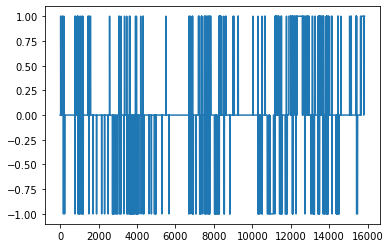

In [117]:
plt.plot(neigh.predict(X[int(len(X)/2):]))

In [118]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X[:int(len(X)/2)], y[:int(len(y)/2)])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

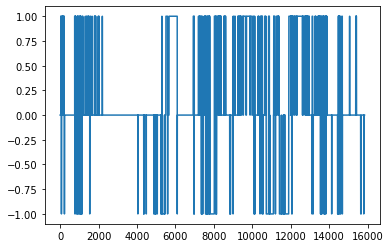

In [119]:
plt.plot(rf.predict(X[int(len(X)/2):]))

In [120]:
tree = tree.DecisionTreeClassifier()
tree.fit(X[:int(len(X)/2)], y[:int(len(y)/2)])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

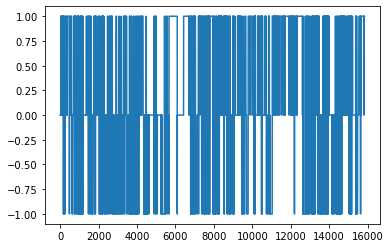

In [121]:
plt.plot(tree.predict(X[int(len(X)/2):]))

In [122]:
testStrategy([dfXMaster, dfYMaster], [simpleSignalsX, simpleSignalsY])

(2.900000000000375, 46916)

In [123]:
testStrategy([dfXMaster[int(len(X)/2):], dfYMaster[int(len(X)/2):]], signalToXY(neigh.predict(X[int(len(X)/2):])))

(0.12250000000001648, 7496)

In [124]:
testStrategy([dfXMaster[int(len(X)/2):], dfYMaster[int(len(X)/2):]], signalToXY(rf.predict(X[int(len(X)/2):])))

(0.18500000000021544, 10768)

In [125]:
testStrategy([dfXMaster[int(len(X)/2):], dfYMaster[int(len(X)/2):]], signalToXY(tree.predict(X[int(len(X)/2):])))

(0.3025000000000375, 17316)